In [29]:
import sys
import os
IMATOOLS_DIR = os.getcwd()+'/..'
sys.path.insert(1, IMATOOLS_DIR)

import pandas as pd 
import numpy as np


In [30]:
from imatools.common import ioutils as iou 

# Locations of hard drive based on platform
dirdic={'macOS'   : '/Volumes/sandisk', 
        'Linux'   : '/media/jsl19/sandisk' , 
        'Windows' : 'D:/'}

p2f = iou.fullfile(dirdic[iou.chooseplatform()], '09-dnav_vs_inav/umc')
name = 'spatial_correspondence.csv'

df = pd.read_csv(iou.fullfile(p2f, 'local',name), skipinitialspace=True)
df_stats = pd.read_csv(iou.fullfile(p2f, 'results_local', 'stats.csv'), skipinitialspace=True)

In [52]:
df

,th_dnav,th_inav,fibrosis_d,fibrosis_i,performance,perf_name
0,1.2,1.2000,0.266154,0.210506,0.213097,jaccard
1,1.2,1.2000,0.266154,0.210506,0.395557,precision
2,1.2,1.2000,0.266154,0.210506,0.315993,recall
3,1.2,1.2000,0.266154,0.210506,0.689721,accuracy
4,1.2,1.2000,0.266154,0.210506,0.351327,dice
...,...,...,...,...,...,...
685,1.2,1.1367,0.635517,0.603082,0.614658,jaccard
686,1.2,1.1367,0.635517,0.603082,0.780417,precision
687,1.2,1.1367,0.635517,0.603082,0.743188,recall
688,1.2,1.1367,0.635517,0.603082,0.704339,accuracy


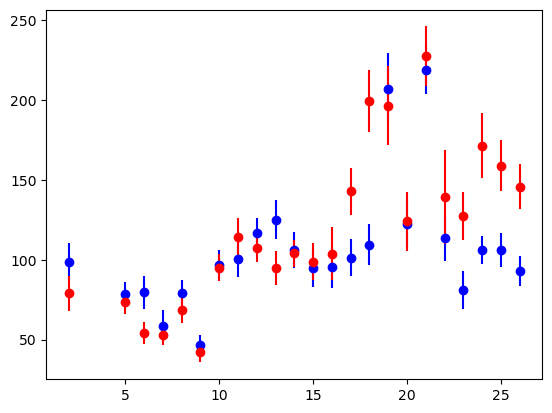

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

xx = True

if xx : 
    plt.errorbar(data=df_stats[df_stats['LGE_TYPE']=='dNAV'], x='CASE', y='MEAN_BP', yerr='SDEV_BP', fmt='ob')
    plt.errorbar(data=df_stats[df_stats['LGE_TYPE']=='iNAV'], x='CASE', y='MEAN_BP', yerr='SDEV_BP', fmt='or')
else :
    sns.scatterplot(data=df_stats, x='CASE', y='FIB_SCORE ', hue='LGE_TYPE')

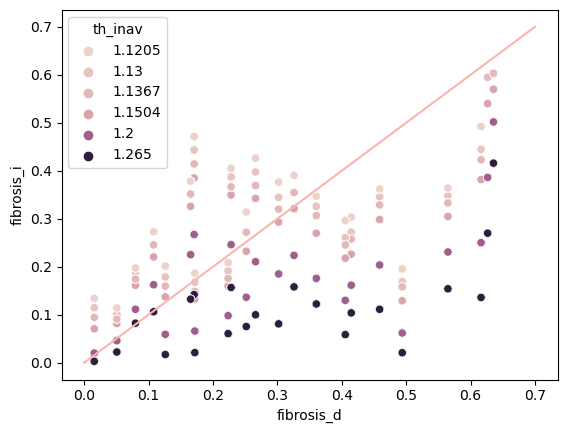

In [75]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

x=np.linspace(0, 0.7, 10)
y=x

sns.set_palette(palette='Pastel1')
sns.scatterplot(data=df, x='fibrosis_d', y='fibrosis_i', hue='th_inav', hue_order=[1.1205, 1.13, 1.1367, 1.1504, 1.2, 1.265])
plt.plot(x,y)


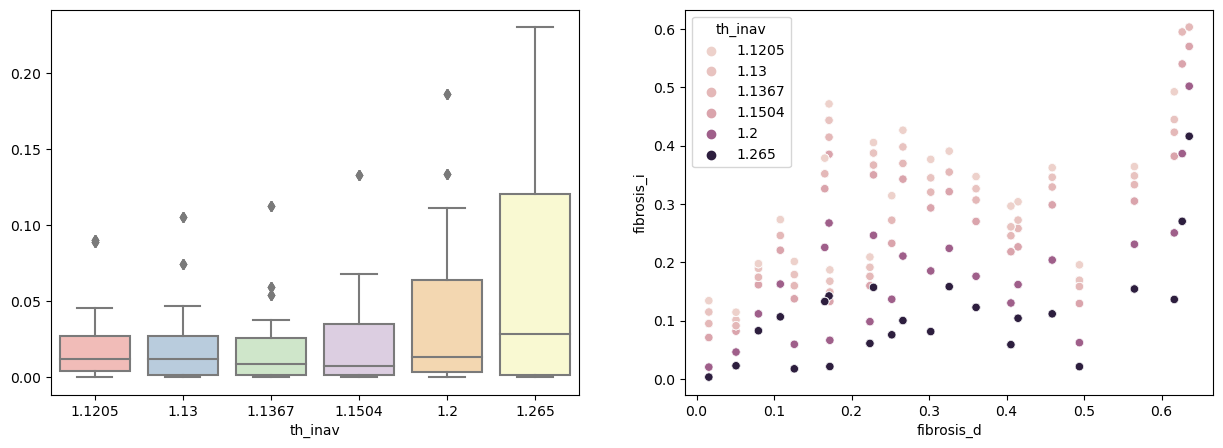

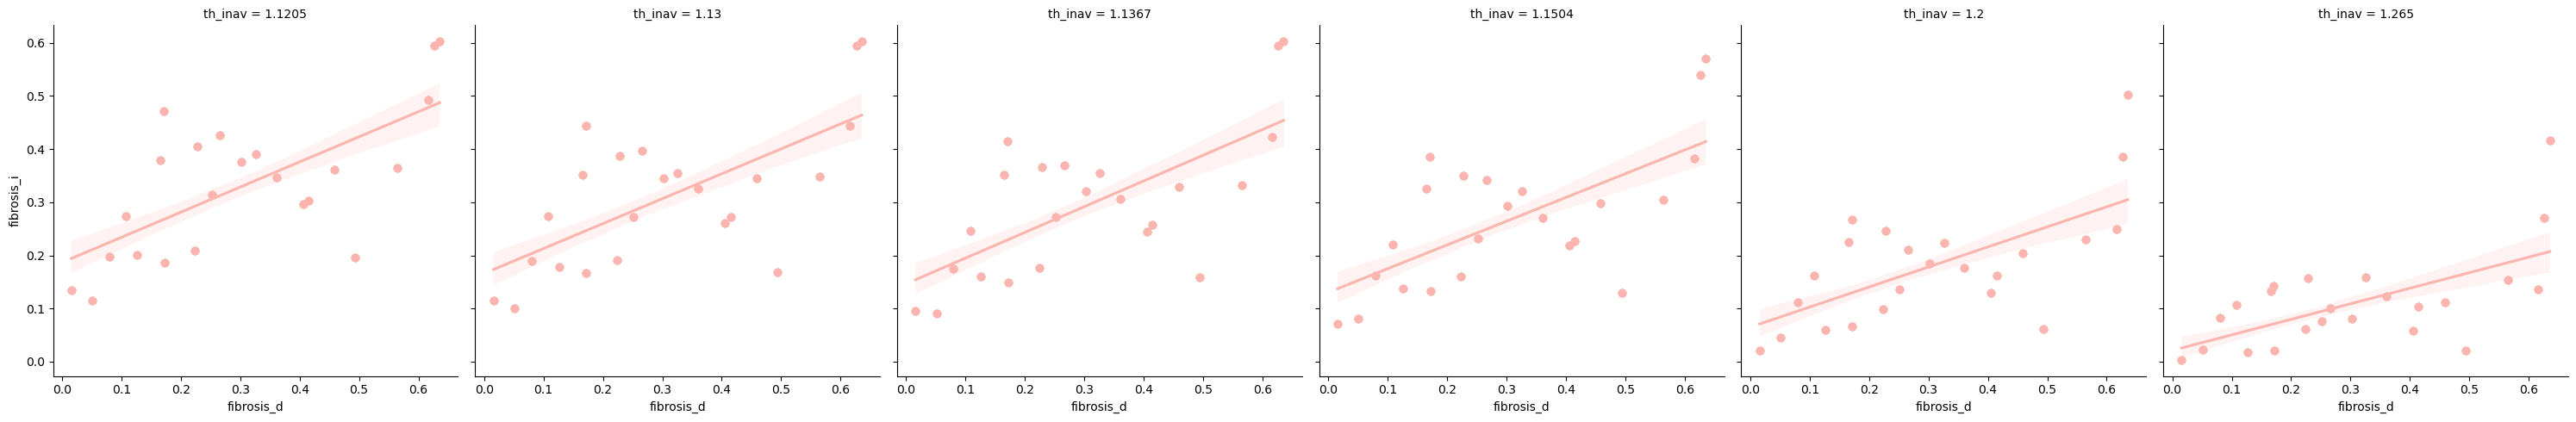

In [99]:

fig, ax = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.set_palette('Pastel1')

sns.boxplot(ax=ax[0], x=df['th_inav'], y=(df['fibrosis_d']-df['fibrosis_i'])
            ** 2, order=[1.1205, 1.13, 1.1367, 1.1504, 1.2, 1.265], 
            whis=1)
sns.scatterplot(ax=ax[1], data=df, x='fibrosis_d', y='fibrosis_i', hue='th_inav', hue_order=[1.1205, 1.13, 1.1367, 1.1504, 1.2, 1.265])

sns.lmplot( data=df, x='fibrosis_d', y='fibrosis_i', col='th_inav', col_order=[1.1205, 1.13, 1.1367, 1.1504, 1.2, 1.265])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


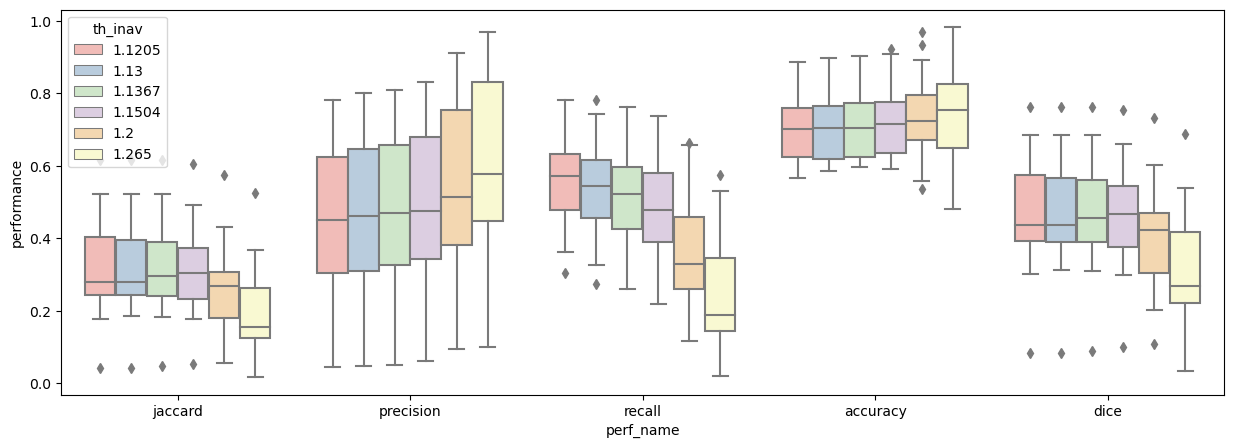

In [66]:

fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.set_palette('Pastel1')
sns.boxplot(ax=ax, data=df, 
    x='perf_name', y='performance', hue='th_inav', whis=1,
    hue_order=[1.1205, 1.13, 1.1367, 1.1504, 1.2, 1.265])

plt.savefig(iou.fullfile(p2f, 'performance.eps'))


In [72]:
metric_name = 'accuracy'
th = [1.1205, 1.13, 1.1367, 1.1504, 1.2, 1.265]

print(metric_name)
for threshold in th :
    # threshold = 1.1205
    metric = df['performance']
    thresh = df['th_inav']

    metric = metric[df['perf_name']==metric_name]
    thresh = thresh[df['perf_name']==metric_name]

    metric = metric[thresh==threshold]

    print('{:.3f} (+/-{:.3f})'.format(np.mean(metric), np.std(metric)))


accuracy
0.702 (+/-0.086)
0.708 (+/-0.089)
0.714 (+/-0.092)
0.719 (+/-0.098)
0.733 (+/-0.118)
0.734 (+/-0.138)
